# **Dog Breed Identification**

In this project, I will build a multi-class image classifier capable of identifying dog breeds using TensorFlow 2.0 and TensorFlow Hub.

## 1. **Problem definition**
Identifying the breed of a dog given an image of a dog.

## 2. **Data**
The data is from Kaggle's [dog breed identification](https://www.kaggle.com/c/dog-breed-identification/data) competition. It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

## 3. **Evaluation**
The evaluation metric defined by [Kaggle](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation) is Multi Class Log Loss between the predict probability and the observed target.

## 4. **Features**
The training set and the set set both have 10,000+ images



#### **Importing tools**

In [1]:
# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub

# Exploratory Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Display images in colab
from IPython.display import Image

# Cross validation
from sklearn.model_selection import train_test_split

# TensorBoard callback
import datetime

# Paths manipulation
import os

# Check for GPU availability
print('GPU', 'available' if tf.config.list_physical_devices('GPU') else 'not available')

GPU available


## **Getting data ready (turning it into tensors)**
For any machine learning model, our data has to be in numerical form and so I will turn the images and labels into tensors (numerical representation).

I will start by importing the labels file and check it out.

In [2]:
# Import labels of the data
labels_df = pd.read_csv('drive/My Drive/Dog Breed Identification/Data/labels.csv')

# View labels
labels_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [3]:
# Information about the labels
labels_df.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     3e9a38dab63eabcfa67fc6677d3f6e9a  scottish_deerhound
freq                                   1                 126

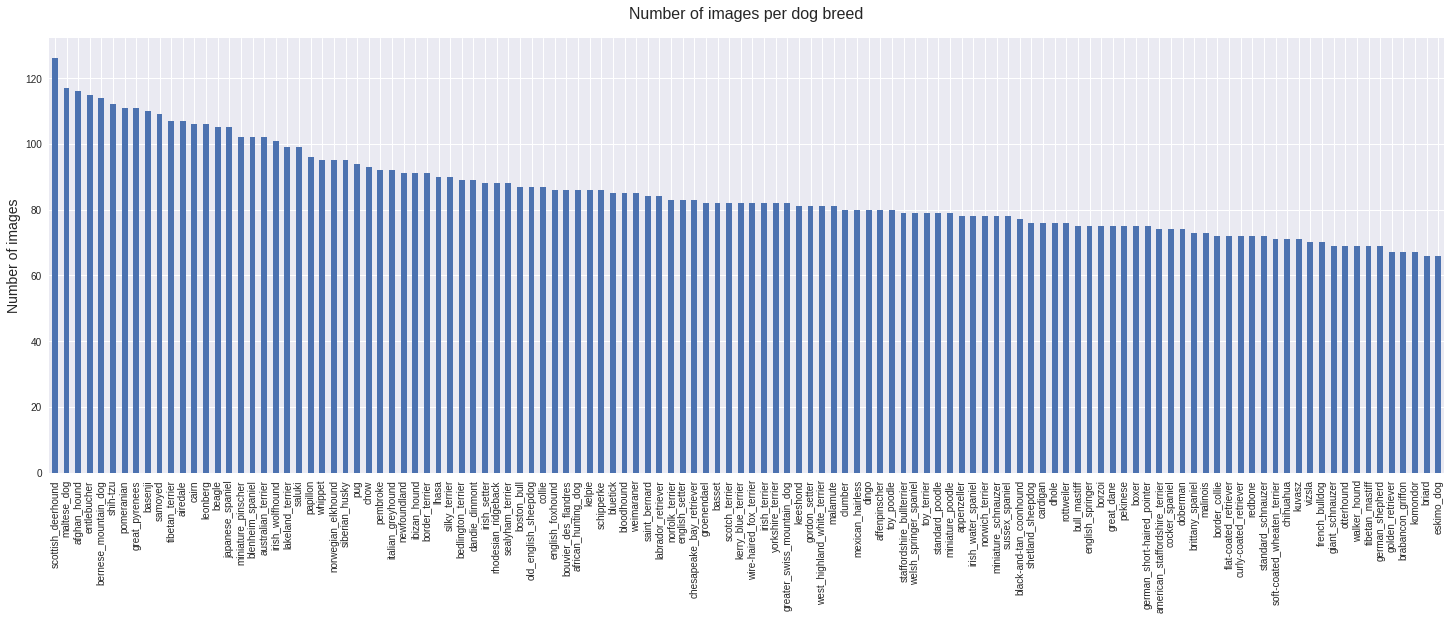

In [4]:
# How many images we have for each dog breed
plt.style.use('seaborn')
labels_df['breed'].value_counts().plot.bar(figsize=(25, 8))
plt.ylabel('Number of images', fontsize=14)
plt.title('Number of images per dog breed', fontsize=16, y=1.03);

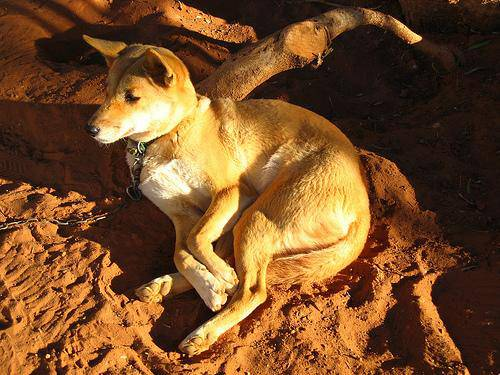

In [5]:
# View an image of the dataset
Image('drive/My Drive/Dog Breed Identification/Data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### **Getting images and their labels**

Since we've got the image ID's and their labels in the `labels_df` DataFrame, I will use the DataFrame to create:

* A list of filepaths to the training set images
* An array of all labels

I will create a list of filepaths to the images rather than importing them all because working with filepaths (strings) is much more efficient than working with images.

In [6]:
# Create filepaths from the image Id's
filepaths = [f'drive/My Drive/Dog Breed Identification/Data/train/{filename}.jpg' for filename in labels_df['id']]

# Check if we have the same amount of filenames as the amount of actual image files
if len(os.listdir('drive/My Drive/Dog Breed Identification/Data/train/')) == len(filepaths):
  print('Amount of filenames matches the amount of actual image files')
else:
  print('Amount of filenames does not match the amount of actual image files')


Amount of filenames does not match the amount of actual image files


In [0]:
# Create label array containing only the labels
labels = np.array(labels_df['breed'])

Since a machine learning model can't take strings as input (which the label values currently are), I will have to convert the labels into numbers.

As the first step, I will find all of the unique dog breed names and store them in `unique_labels`. Then I will use `unique_labels` to help turn the `labels` array into an array of booleans by comparing each label to `unique_labels` and the label value will be replaced with an array indicating which dog breed is the real label (True) and which ones aren't (False).

In [8]:
# Get unique labels from the labels array
unique_labels = np.unique(labels)

# Turn each label into an array of booleans
boolean_labels = [label == unique_labels for label in labels]

# Check if it worked
boolean_labels[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

### **Splitting data into training and validation sets**

To evaluate the models, I will split the data into training and validation sets. However, I will start by using a sample of the data, given that experimenting on a dataset of 10000+ images can take a long time. I will start off by using a sample of 1000 images and increase as needed.

In [0]:
# Number of images to use
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [10]:
# Assign data to X and y
X = filepaths
y = boolean_labels

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

# Check shapes of variables
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### **Preprocessing images (turning images into Tensors)**

The labels are in numeric format but the images are still just file paths.

Since I am using TensorFlow, the data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. Tensors are multi-dimensional arrays, kind of like NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess the images into Tensors I will write a function which does the following steps:

* Take an image filepath as input
* Use Tensorflow to read the file and save it to a variable `image`
* Turn the `image` into Tensors
* Normalize the `image` (convert color channels values from 0-255 to 0-1)
* Resize the `image` to be of shape (224, 224)
* Return the modified `image`

The shape (224, 224) refers to (heigh, width). This will be the size of input the model takes, which is images of 224x224 pixels.

An image is composed of pixels and each pixel has a certain value of red, green and blue between 0 and 255. These are referred to as colour channels. As such the complete shape of each image will be (224, 224, 3) in which the 3 refers to the red, blue and green values of each pixel.

I defined this shape because I will be using a pre-trained model which takes images of shape (224, 224) as input.

In [0]:
# Define image size
IMG_SIZE = 224

# Preprocessing function
def process_image(filepath):
  '''
  Takes an image filepath and turns the image into a Tensor
  '''
  # Read image file
  image = tf.io.read_file(filepath)

  # Turn image into a numerical Tensor with 3 color channels (red, blue and green)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the colour channel values from 0-255 into a scale of 0-1
  # This normalization makes the computations more efficient
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to the desired shape (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


### **Turning the data into batches**

Now that I've got a function to convert images into Tensors, I will write one to turn the data into batches (more specifically, a TensorFlow BatchDataset).

A batch (also called mini-batch) is a small portion of the data, for example, 32 images and the corresponding labels (32 is generally the default batch size). In deep learning, instead of finding patterns in an entire dataset at the same time, we often find them one batch at a time.

This is because when we are dealing with large datasets like this one, these files may take up more memory than our GPU has. Trying to compute on them all would result in an error. So instead, it's more efficient to create smaller batches of our data and compute on one batch at a time.

TensorFlow is very efficient when our data is in batches of (data, label) Tensor tuples. So I will start by creating a quick function to create these Tensor tuples.

In [0]:
# Function that creates Tensor tuples (image, label)
def tensor_tuples(filepath, label):
  '''
  Takes an image filepath and the corresponding label, processes the image and returns a tuple (image, label)
  '''
  image = process_image(filepath)

  return (image, label)

Now that I have a way of turning the data into Tensor tuples of form `(image, label)`, I will write a function to turn all of the data into batches and run it for the training and validation sets.

In [0]:
# Set batch size
BATCH_SIZE = 32

# Function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_set=False, test_set=False):
  '''
  Creates batches of data out of image (X) and label (y) pairs.
  It also works when dealing with a test set, which has no labels (y).
  Shuffles the data if dealing with training set but doesn't shuffle it if dealing with validation set.
  '''
  # If dealing with test set (no labels)
  if test_set:
    print('Creating test data batches...')

    # Turns whole test set into a TensorFlow Dataset
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))

    # Because the test set has no labels, I call process_images directly instead of tensor_tuples
    # After processing the images, It will create batches of size BATCH_SIZE
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If dealing with validation set
  elif valid_set:
    print('Creating validation data batches...')

    # Turns whole validation set into a TensorFlow Dataset
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    # Because the validation set has labels, I call tensor_tuples which automatically calls process_image
    data_batch = data.map(tensor_tuples).batch(BATCH_SIZE)
    return data_batch

  # If dealing with training set
  else:
    print('Creating training data batches...')

    # Turns whole validation set into a TensorFlow Dataset
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    # Shuffle the whole data
    data = data.shuffle(buffer_size=len(X))

    # Because the training set has labels, I call tensor_tuples which automatically calls process_image
    data_batch = data.map(tensor_tuples).batch(BATCH_SIZE)
    return data_batch

In [14]:
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_set=True)

Creating training data batches...
Creating validation data batches...


In [15]:
# Check attributes of the data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

**Visualizing data batches**

I will create a short function to view the images in a data batch.

In [0]:
def visualize_data_batch(images, labels):
  #Set up figure
  plt.figure(figsize=(10, 15))

  # Iterate through all the images in a data batch
  for i in range(len(images)):
    # Create subplots (8 rows, 4 columns)
    ax = plt.subplot(8, 4, i + 1)

    # Display an image
    plt.imshow(images[i])

    # Add the image label as the title
    plt.title(unique_labels[labels[i].argmax()])

    # Turn grid lines off
    plt.axis('off')

To visualize a data batch, I need to turn the data grouped in batches into something that can be iterated over using `as_numpy_iterator()`. Then by passing the iterable data to `next()`, I will get the next item in the iterator which, in this case, is a batch of 32 image and label pairs.

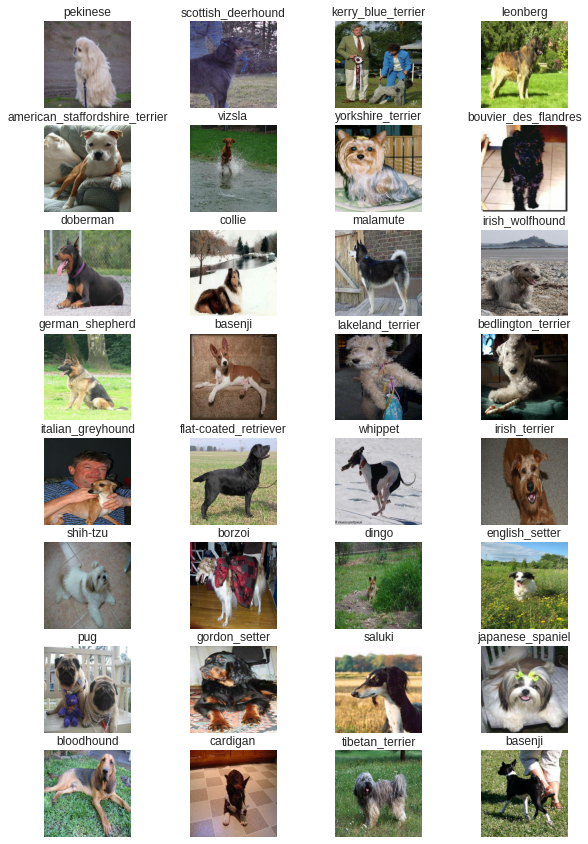

In [17]:
train_images, train_labels = next(train_data.as_numpy_iterator())

# Visualize data batch
visualize_data_batch(train_images, train_labels)

## **Modelling**

Now that the data is ready, I can proceed to modelling. I will use an existing model from TensorFlow Hub.

TensorFlow Hub is a resource where we can find pre-trained machine learning models for the problem we are working on. Using a pre-trained machine learning model is often referred to as **transfer learning**.

I will use a pre-trained model because building a model and training it from scratch can be expensive and time consuming. Transfer learning is useful because we can take what another model has learned and use that information on our own problem.

After searching for image classification in TensorFlow Hub, I will use the [mobilenet_v2_130_224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) model. This model has been trained in image classification and takes an input of images in the shape (224, 224), which is how my data is processed.

### Building a model

Before I build a model, there are a few things I need to define:

* The input shape (images in the form of Tensors) for the model.
* The output shape (image labels, in the form of Tensors) of the model.
* The URL of the pre-trained model I want to use

In [0]:
# Set input shape for the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Set output shape of the model
OUTPUT_SHAPE = len(unique_labels)

# Set URL of pre-trained model
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

Now that I have defined the inputs, the outputs and the model I will use, I will write a function which does the following:

* Takes the input shape, output shape and the model's URL as parameters
* Defines the layers in a Keras model in a sequential fashion (step-by-step process)
* Compiles the model (says how it should be evaluated and improved)
* Builds the model (tells the model what kind of input shape it will be getting)
* Returns the model

In [0]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  # Set the model's layers
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url), # input layer
    tf.keras.layers.Dense(units=output_shape, activation='softmax') # output layer
  ])
  
  # Compile the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
  
  # Build the model
  model.build(input_shape)

  return model

I will break down what is happening in the function in order to understand it better:

1. I start off by setting the model's layers:
  * The first layer of the model is the pre-trained model from TensorFlow Hub (hub.KerasLayer(model_url). So the first layer is actually an entire model which has many more layers. This input layer takes the images and finds patterns in them based on the patterns the pre-trained model has found.
  * The second layer (tf.keras.layers.Dense()) is the output layer of the model. It brings all of the patterns discovered in the input layer together and outputs it in the shape I want which is 120 (the number of unique dog breeds). 
  * The `activation="softmax"` parameter tells the output layer that we would like to assign a probability value to each of the 120 labels somewhere between 0 & 1. The higher the value, the more the model believes the input image should have that label.

2. Then I compile the model:
  * The loss function is the function that we are trying to minimize (the lower the value, the better the model performs)
  * The Adams optimization algorithm is used in order to find the best set of weights for the model
  * The accuracy metric tells us how well the model is predicting the labels of the images

3. Finally I build the model:
  * I use model.build() to tell the model what input shape it can expect since I am using a pre-trained model as the input layer.

Now that I understand the function better, I will create a model and check some details about it.

In [20]:
# Create a model and check its details
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


The non-trainable parameters are the patterns learned by mobilenet_v2_130_224 (pre-trained model) and the trainable parameters are the ones in the dense layer I added.

This means that the main bulk of the information in the model has already been learned previously and I am going to take that and adapt it to the problem I am working on.


### **Creating callbacks**

The model has been created but before I train it, I will make some callbacks.

Callbacks are helper functions that a model can use during training to do things like save a model's progress, check a model's progress or stop training early if a model stops improving.

The two callbacks I am going to add are a TensorBoard callback and an Early Stopping callback.

**TensorBoard Callback**

TensorBoard helps provide a visual way to monitor the progress of the model during and after training.

It can be used directly in a notebook to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in the notebook, I need to do three things:

* Load the TensorBoard notebook extension
* Create a TensorBoard callback which is able to save logs to a directory and pass it to the model's `fit()` function
* Visualize the model's training logs using the `%tensorboard` magic function (I will do this after training the model)

In [0]:
# Load TensorBoard notebook extension
%load_ext tensorboard

# Function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory to store TensorBoard logs
  logdir = os.path.join('drive/My Drive/Dog Breed Identification/Logs',
                        # Make it so the logs get tracked whenever I run an experiment (create training logs for the current date and time every time i fit the model)
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  
  return tf.keras.callbacks.TensorBoard(logdir)

**Early Stopping callback**

Early stopping helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

In [0]:
# Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

### **Training a model**

The first model is only going to use 1000 images as I had mentioned previously. It will be trained on 800 images and then validated on 200 images.

The final parameter that I will define before training the model is the **number of epochs**.

Number of epochs defines how many passes of the data we would like our model to do. With each pass of the data, the model adjusts the weights it has learned to correct the predictions it got wrong and improve itself.

The value of number of epochs is hard to define. This is one of the reasons why I created an early stopping callback. Having early stopping setup means if I set `NUM_EPOCHS` to 100 but the model stops improving after 22 epochs, it will stop training to prevent overfitting.

After defining the number of epochs, I will write a function which trains the model by running the following steps:

* Create a model using `create_model()`
* Set up a TensorBoard callback using `create_tensorboard_callback()` (I do this here so it creates a log directory of the current date and time)
* Call the `fit()` function on the model and pass it the training set, validation set, number of epochs to train for and the callbacks
* Return the fitted model

In [0]:
# Set number of epochs (number of times that the model will pass through the data)
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

# Function to train model
def train_model():
  '''
  Trains a given model and returns the trained model
  '''
  # Create a model
  model = create_model()

  # Set up TensorBoard callback
  tensorboard = create_tensorboard_callback()

  # Fit model to the data
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  return model

In [24]:
# Train model
model = train_model()

Epoch 1/100
25/25 [==============================] - 507s 20s/step - loss: 4.6611 - accuracy: 0.0737 - val_loss: 3.5695 - val_accuracy: 0.2650
Epoch 2/100
25/25 [==============================] - 7s 267ms/step - loss: 1.6686 - accuracy: 0.6825 - val_loss: 2.1911 - val_accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 7s 272ms/step - loss: 0.5631 - accuracy: 0.9475 - val_loss: 1.6955 - val_accuracy: 0.5700
Epoch 4/100
25/25 [==============================] - 7s 270ms/step - loss: 0.2534 - accuracy: 0.9912 - val_loss: 1.4920 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 7s 269ms/step - loss: 0.1461 - accuracy: 1.0000 - val_loss: 1.4183 - val_accuracy: 0.6200
Epoch 6/100
25/25 [==============================] - 7s 272ms/step - loss: 0.1014 - accuracy: 0.9987 - val_loss: 1.3664 - val_accuracy: 0.6350
Epoch 7/100
25/25 [==============================] - 7s 272ms/step - loss: 0.0756 - accuracy: 1.0000 - val_loss: 1.3302 - val_accuracy: 0.6250

We can see that the model is overfitting since it has much higher accuracy in the training set (100%) than in the validation set (63%). This means that by using a larger dataset, the model will perform better and generalize better to new data.

### **Checking TensorBoard logs**

I can visualize the performance of the model by checking the TensorBoard logs.

The TensorBoard magic function `%tensorboard` will access the logs directory created earlier and visualize its contents.

In [25]:
%tensorboard --logdir drive/My\ Drive/Dog\ Breed\ Identification/Logs

<IPython.core.display.Javascript object>


Thanks to the early_stopping callback, the model stopped training after 9 epochs because the validation accuracy failed to improve for 3 epochs.

### **Making and visualizing predictions**

The prediction made by the model for each image is an array of probabilities. Each value in the array is the probability value that a certain dog breed is the label for the image. The higher the value, the more likely the model thinks that a certain dog breed is the label of the image.

I will turn these arrays of probabilities into labels and then display the image with the corresponding true and predicted labels. Alongside the displayed image, I will plot a bar graph showing the top 10 probability values for the predicted label since it would be interesting to see what other guesses the model is making.

Since the validation data is in batch form, to get a list of images and labels, I will have to unbatch it and then turn it into an iterator.

In [0]:
# Making predictions on the validation set
predictions = model.predict(valid_data)

# Turn predictions into string labels
label_indices = predictions.argmax(axis=1) # Find index of maximum probability value for each image
label_max_probabilities = predictions.max(axis=1)
predicted_labels = unique_labels[label_indices]

# Initialize list of images and actual labels
images_ = []
labels_ = []

# Loop through each (image, label) tuple
for image, label in valid_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(unique_labels[label.argmax()])

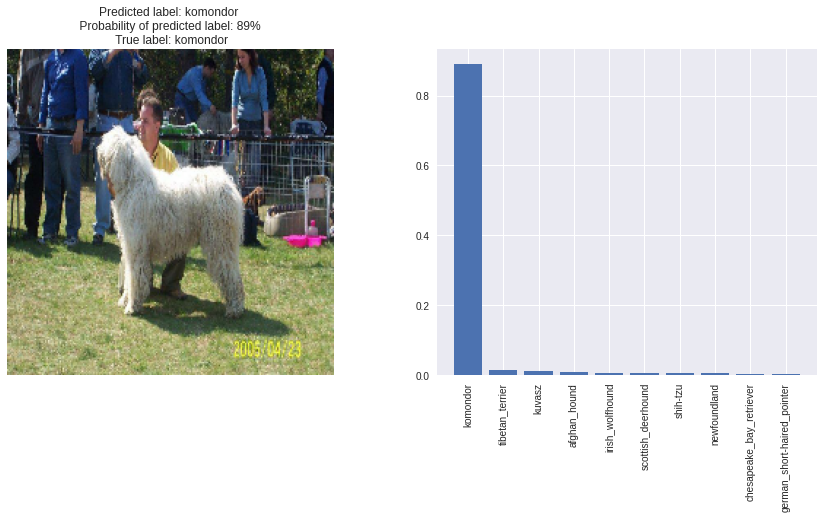

In [27]:
# Function to display random image with corresponding labels and bar graph of top 10 probabilitiy values
def plot_prediction(images_, labels_, predicted_labels, label_max_probabilities, predictions):
  '''
  Display a random image with the predicted and true labels and bar graph showing the top 10 probability values for the predicted label
  '''
  # Get random index
  random_index = np.random.randint(0, len(images_))

  # Display image
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
  ax1.imshow(images_[random_index])
  ax1.set_xticks([]) # Disable x-axis
  ax1.set_yticks([]) # Disable y-axis

  # Plot bar graph with top 10 probability values for image label
  top_10_preds = predictions[random_index].argsort()[::-1][:10] # Indices of top 10 predictions
  ax2.bar(np.arange(len(top_10_preds)),
          predictions[random_index][top_10_preds])
  ax2.set_xticks(np.arange(len(top_10_preds)))
  ax2.set_xticklabels(unique_labels[top_10_preds], rotation = 90)

  # Predicted and true labels
  ax1.set_title('Predicted label: {} \n Probability of predicted label: {:2.0f}% \n True label: {}'.format(predicted_labels[random_index],
                                                                                                      label_max_probabilities[random_index] * 100,
                                                                                                      labels_[random_index]))
  
# Run 'plot_prediction'
plot_prediction(images_, labels_, predicted_labels, label_max_probabilities, predictions)

### **Saving and loading a trained model**

The file extension of a saved Keras model is .h5. So I will create a function which takes a model as input and uses the `save()` method to save it as a h5 file to a specified directory.



In [0]:
# Function to save trained model
def save_model(model, suffix=None):
  '''
  Saves a given model in a directory and appends a suffix (string) with some information about the model
  '''
  # Crate model directory pathname with current timestamp
  model_dir = os.path.join('drive/My Drive/Dog Breed Identification/Models',
                           datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  
  # Add suffix and file extension
  model_path = model_dir + '-' + suffix + '.h5'

  # Save model
  model.save(model_path)

  return model_path

To load a model, I will create another a function which takes a model's path and uses the `tf.keras.models.load_model()` function to load it.

Because I am using a component from TensorFlow Hub (hub.KerasLayer) I will have to pass this as a parameter to the `custom_objects` parameter.

In [0]:
# Function to load trained model
def load_model(model_path):
  '''
  Loads a saved model from a specified path
  '''
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={'KerasLayer': hub.KerasLayer})
  
  return model

Now I will save and load the model trained on 1000 images.

In [30]:
# Save model trained on 1000 images
model_path = save_model(model, suffix='1000-images-mobilenetv2-Adam')

# Load model trained on 1000 images
loaded_1000_image_model = load_model(model_path)

# Check if loaded model is working
loaded_1000_image_model.evaluate(valid_data)

7/7 [==============================] - 1s 172ms/step - loss: 1.2908 - accuracy: 0.6300


[1.2907637357711792, 0.6299999952316284]

### **Training a model on the entire dataset**



In [31]:
# Create data batch with entire dataset
full_data = create_data_batches(X, y)

# Create a model
full_model = create_model()

# Create Early Stopping callback
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

# Train model
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_early_stopping])

# Save model trained on entire dataset
full_model_path = save_model(full_model, suffix='entire-dataset-mobilenetv2-Adam')

Creating training data batches...
Epoch 1/100
320/320 [==============================] - 3802s 12s/step - loss: 1.3379 - accuracy: 0.6725
Epoch 2/100
320/320 [==============================] - 75s 235ms/step - loss: 0.3951 - accuracy: 0.8825
Epoch 3/100
320/320 [==============================] - 76s 237ms/step - loss: 0.2327 - accuracy: 0.9384
Epoch 4/100
320/320 [==============================] - 78s 243ms/step - loss: 0.1521 - accuracy: 0.9609
Epoch 5/100
320/320 [==============================] - 81s 254ms/step - loss: 0.1048 - accuracy: 0.9786
Epoch 6/100
320/320 [==============================] - 80s 251ms/step - loss: 0.0766 - accuracy: 0.9870
Epoch 7/100
320/320 [==============================] - 81s 253ms/step - loss: 0.0584 - accuracy: 0.9918
Epoch 8/100
320/320 [==============================] - 83s 260ms/step - loss: 0.0470 - accuracy: 0.9936
Epoch 9/100
320/320 [==============================] - 76s 238ms/step - loss: 0.0377 - accuracy: 0.9952
Epoch 10/100
320/320 [========

In [0]:
# Load trained model
loaded_full_model = load_model(full_model_path)

### **Making predictions on the test set**

Since the model has been trained on images in the form of Tensor batches, to make predictions on the test set, I will have to get it into the same format.

To make predictions on the test data, I will:
* Get the test image filepaths
* Convert the filepaths into test data batches using `create_data_batches()` and setting the `test_set` parameter to True (since there are no labels with the test images)
* Make predictions by passing the test data batches to the `predict()` function

In [33]:
# Filepaths for test set images
test_path = 'drive/My Drive/Dog Breed Identification/Data/test/'
test_filepaths = [test_path + filename for filename in os.listdir(test_path)]

# Create test data batch
test_data = create_data_batches(test_filepaths, test_set=True)

# Make predictions on test set
test_predictions = loaded_full_model.predict(test_data, verbose=1)

# Save predictions to csv file
np.savetxt('drive/My Drive/Dog Breed Identification/predictions.csv', test_predictions, delimiter=',')

Creating test data batches...
324/324 [==============================] - 4201s 13s/step


In [0]:
# Load predictions
test_predictions = np.loadtxt('drive/My Drive/Dog Breed Identification/predictions.csv', delimiter=',')

## **Submission to Kaggle**

After having done predictions on the test set, it is time to submit them to Kaggle and see how I do in the leaderboard.

Looking at the Kaggle sample submission, to create my submission file, I will have to go through the following steps:
* Create a pandas DataFrame with an 'id' column as well as a column for each dog breed
* Add data to the 'id' column by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns
* Export the DataFrame as a CSV file

In [0]:
# Create a pandas DataFrame with empty columns
submission_df = pd.DataFrame(columns=['id'] + list(unique_labels))

# Append test image ID's to 'id' column
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
submission_df['id'] = test_ids

# Append predicted probabilities for the test set
submission_df[list(unique_labels)] = test_predictions

# Save DataFrame to a csv file
submission_df.to_csv('drive/My Drive/Dog Breed Identification/submission.csv', index=False)